In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
(training_set,validation_set),dataset_info = tfds.load('tf_flowers',
                                                      split=['train[:70%]','train[70%:]'],
                                                      with_info=True,
                                                      as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
num_classes = dataset_info.features['label'].num_classes

In [ ]:
num_classes

5

In [ ]:
num_training_examples = 0
num_validation_examples = 0
for example in training_set:
    num_training_examples += 1
for example in validation_set:
    num_validation_examples += 1

In [ ]:
num_training_examples

2569

In [ ]:
num_validation_examples

1101

In [ ]:
print("Total number of classes: {}".format(num_classes))
print("Total numbers of Training Images: {}".format(num_training_examples))
print("Total numbers of validation Images: {}\n".format(num_validation_examples))

Total number of classes: 5
Total numbers of Training Images: 2569
Total numbers of validation Images: 1101



In [ ]:
for i,examples in enumerate(training_set.take(5)):
    print("Image {} shape: {} label: {}".format(i+1,examples[0].shape,examples[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [ ]:
IMG_RES = 224
def format_image(image,label):
    image = tf.image.resize(image,(IMG_RES,IMG_RES))/255.0
    return image, label

In [ ]:
BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [ ]:
feature_extractor = hub.KerasLayer(URL,input_shape=(IMG_RES,IMG_RES,3))

In [ ]:
feature_extractor.trainable = False

In [ ]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(num_classes)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [ ]:
Epochs = 6
history = model.fit(train_batches,epochs=Epochs,
                   validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 107s 1s/step - loss: 0.7425 - accuracy: 0.7353 - val_loss: 0.4484 - val_accuracy: 0.8529
Epoch 2/6
81/81 [==============================] - 93s 1s/step - loss: 0.3765 - accuracy: 0.8782 - val_loss: 0.3650 - val_accuracy: 0.8828
Epoch 3/6
81/81 [==============================] - 96s 1s/step - loss: 0.3106 - accuracy: 0.8949 - val_loss: 0.3341 - val_accuracy: 0.8865
Epoch 4/6
81/81 [==============================] - 95s 1s/step - loss: 0.2514 - accuracy: 0.9194 - val_loss: 0.3066 - val_accuracy: 0.8919
Epoch 5/6
81/81 [==============================] - 107s 1s/step - loss: 0.2146 - accuracy: 0.9397 - val_loss: 0.2886 - val_accuracy: 0.9001
Epoch 6/6
81/81 [==============================] - 100s 1s/step - loss: 0.1928 - accuracy: 0.9459 - val_loss: 0.2926 - val_accuracy: 0.8992


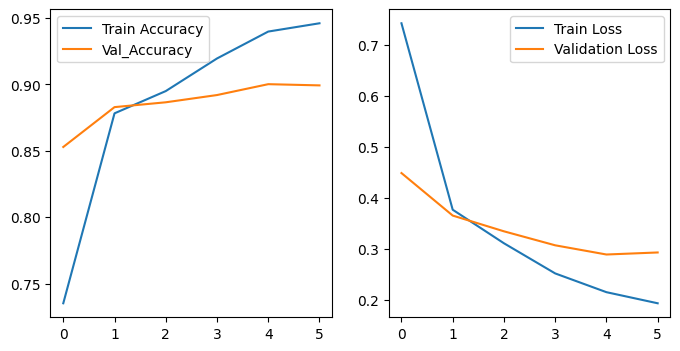

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(Epochs)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Train Accuracy')
plt.plot(epochs_range,val_acc,label='Val_Accuracy')
plt.legend(loc=0)
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Train Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc=0)
plt.show()

In [ ]:
class_names = np.array(dataset_info.features['label'].names)

In [ ]:
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [ ]:
image_batch,label_batch = next(iter(train_batches))


In [ ]:
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [ ]:
predicted_batch = model.predict(image_batch)

1/1 [==============================] - 2s 2s/step


In [ ]:
predicted_batch = tf.squeeze(predicted_batch).numpy()

In [ ]:
predicted_batch

array([[ 4.8145    , -3.844209  , -3.9387114 , -2.5855668 , -7.0121512 ],
       [-4.6763377 , -5.8961215 , -2.0080085 , -4.8026695 ,  3.4679177 ],
       [-4.694117  , -1.031432  , -2.81412   ,  2.351335  , -3.8596148 ],
       [ 5.2962637 , -6.037427  , -3.7663069 , -6.4499393 , -5.294797  ],
       [-2.003674  ,  4.7558117 , -2.312247  , -1.0826807 , -5.4111423 ],
       [ 5.6360464 , -3.159603  , -4.780837  , -4.204463  , -7.432406  ],
       [-0.9026196 , -0.5583965 , -0.5186144 , -3.8981597 , -5.106712  ],
       [ 0.6187564 ,  2.5142343 , -2.9382617 , -2.6458035 , -5.48233   ],
       [-2.09591   ,  2.483347  , -2.529646  ,  0.435605  , -2.8112597 ],
       [-2.707067  , -4.5927954 , -1.0428663 , -2.7581258 ,  3.1666784 ],
       [-4.1384845 , -4.9402914 ,  2.5145361 , -7.3785796 , -5.118184  ],
       [-1.2964462 ,  2.6604464 , -2.955689  , -1.806168  , -4.375716  ],
       [-3.7781591 , -2.0273595 ,  2.2236888 , -5.3969874 , -3.378133  ],
       [-4.2812285 , -1.6038158 ,  1.2

In [ ]:
predicted_ids = np.argmax(predicted_batch,axis=-1)

In [ ]:
predicted_ids

array([0, 4, 3, 0, 1, 0, 2, 1, 1, 4, 2, 1, 2, 2, 2, 4, 1, 1, 3, 0, 3, 2,
       3, 3, 2, 2, 0, 1, 3, 4, 0, 0])

In [ ]:
predicted_class_names = class_names[predicted_ids]

In [ ]:
predicted_class_names

array(['dandelion', 'roses', 'sunflowers', 'dandelion', 'daisy',
       'dandelion', 'tulips', 'daisy', 'daisy', 'roses', 'tulips',
       'daisy', 'tulips', 'tulips', 'tulips', 'roses', 'daisy', 'daisy',
       'sunflowers', 'dandelion', 'sunflowers', 'tulips', 'sunflowers',
       'sunflowers', 'tulips', 'tulips', 'dandelion', 'daisy',
       'sunflowers', 'roses', 'dandelion', 'dandelion'], dtype='<U10')

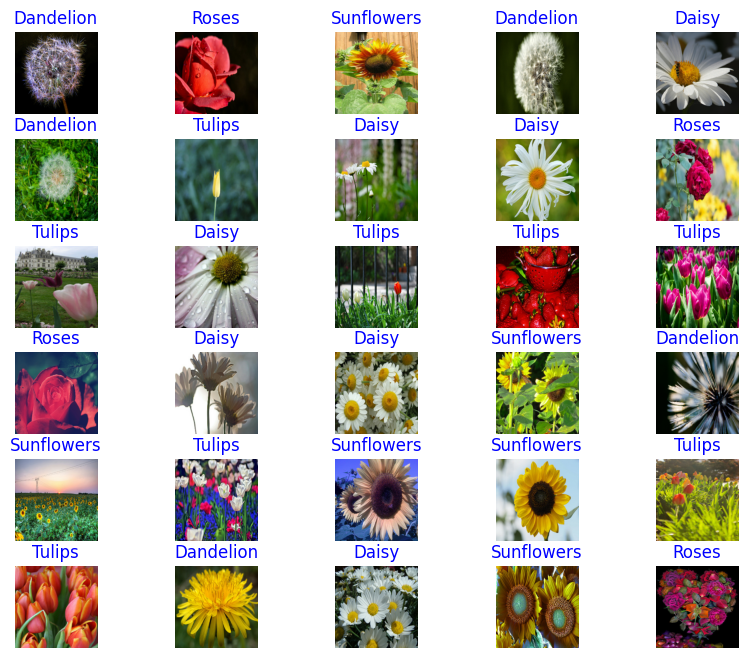

In [ ]:
plt.figure(figsize=(10,8))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n]==label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(),color=color)
    plt.axis('off')